## (dev notebook)

In [1]:
import inference_gym.using_jax as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('./sampler-comparison')
sys.path.append('../../')
from sampler_comparison.samplers import samplers
import seaborn as sns



2025-04-21 12:54:06.191225: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# # from sampler_evaluation.models import banana

# # banana().exact_sample(key=jax.random.key(0))
# # model = Dirichlet(ndims=2, alpha=10.0)
# # model.sample(seed=jax.random.key(0))
# # model.default_event_space_bijector(jnp.ones((2,)))

# import numpy as np
# import oryx
# import jax.numpy as jnp
# # bijector = oryx.bijectors.IteratedSigmoidCentered(
# #     validate_args=False, name='iterated_sigmoid'
# # )
# # bijector(np.ones((2,)))

# oryx.bijectors.IteratedSigmoidCentered().forward(jnp.array([0., 0., 0.]))


In [8]:
# import oryx

# bijector = oryx.bijectors.IteratedSigmoidCentered(
#     validate_args=False, name='iterated_sigmoid'
# )
# bijector.forward_log_det_jacobian

<bound method Bijector.forward_log_det_jacobian of <tfp.bijectors.IteratedSigmoidCentered 'iterated_sigmoid' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>>

In [2]:
# import os
# # os.listdir("../../../../../../r")
# os.listdir("/global/homes/r/reubenh/blackjax-benchmarks/sampler-comparison")

In [3]:
import tensorflow.compat.v2 as tf
import numpy as np
# import tensorflow_probability as tfp
import tensorflow_probability.substrates.jax as tfp
from inference_gym.targets import model
import jax.numpy as jnp

tfb = tfp.bijectors
tfd = tfp.distributions

ndims = 2

dirichlet = tfp.distributions.Dirichlet(
        np.ones(ndims) * 100.0,
        validate_args=False,
        allow_nan_stats=True,
        force_probs_to_zero_outside_support=False,
        name='Dirichlet'
    )

dirichlet.mean(), dirichlet.stddev()

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


(Array([0.5, 0.5], dtype=float32),
 Array([0.03526728, 0.03526728], dtype=float32))

In [4]:
# dirichlet.unnormalized_log_prob(dirichlet.sample(seed=jax.random.key(0)))

In [2]:
# # model.sample(seed=jax.random.key(0))
# model = banana()
# model.sample(seed=jax.random.key(0))

In [2]:
from sampler_evaluation.models import models
# from sampler_evaluation.models.standardgaussian import Gaussian
import sampler_evaluation
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_evaluation.models.dirichlet import Dirichlet
from sampler_evaluation.models.banana import banana
# import oryx
# sampler_evaluation.models.Rosenbrock(D=1)
model = Dirichlet(ndims=2, alpha=100.0)
# model = IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')
# model = banana()
# model.sample(seed=jax.random.key(0))
# model._unnormalized_log_prob(jnp.ones(2))

samples, metadata = samplers['nuts'](return_samples=True)(
        # model=gym.targets.rosenbrock.Rosenbrock(D=2), 
        model=model, 
        num_steps=1000,
        # initial_position=model.sample(seed=jax.random.key(0)), 
        initial_position=jnp.ones((1,)), 
        key=jax.random.PRNGKey(0))


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

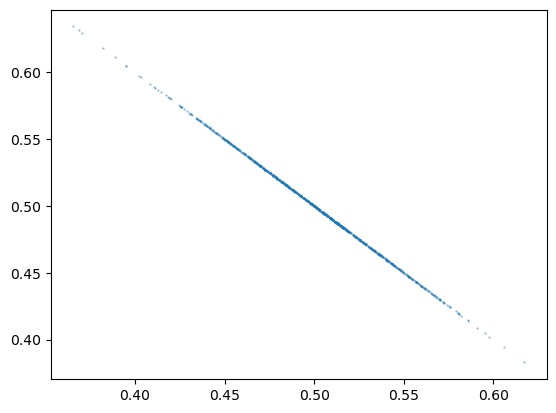

In [3]:
# scatter plot of samples
# samples[0]
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)

In [4]:
samples.mean(axis=0)
# jax.vmap(lambda k: model.sample(seed=k))(jax.random.split(jax.random.key(0), 1000)).mean(axis=0)

Array([0.5008018, 0.4991982], dtype=float32)

In [6]:
from sampler_evaluation.models import models
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error


keys = jax.random.split(jax.random.key(0), 10)
init_keys = jax.random.split(jax.random.key(0), 10)
initial_position = jax.vmap(lambda key: initialize_model(model, key))(init_keys)

squared_errors, metadata = jax.vmap(
        lambda key, pos: samplers['nuts'](return_samples=False)(
        model=model, num_steps=2000, initial_position=pos, key=key
        )
        )(
        keys,
        initial_position,
        )

err_t_max_x2 = jnp.median(squared_errors['identity']['max'], axis=0)
samples_to_low_max_x2 = samples_to_low_error(
err_t_max_x2)* metadata["num_grads_per_proposal"].mean()

final error is 0.0007830436807125807


Array(710.2451, dtype=float32)

Array(1.4101266e-06, dtype=float32)

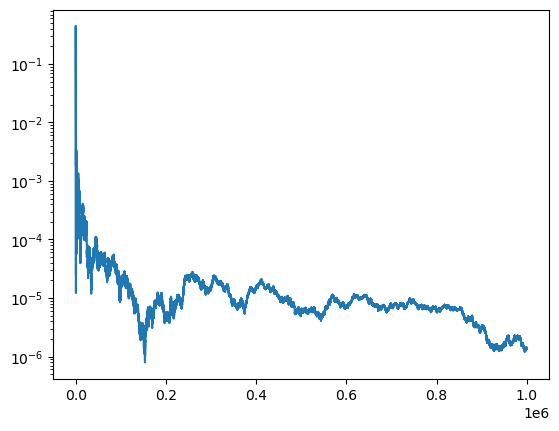

In [15]:
# samples.shape
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error

error_at_each_step = get_standardized_squared_error(
    jnp.expand_dims(samples,0), 
    f=model.sample_transformations["square"],
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2
    )

error_at_each_step.shape

# gradient_calls_per_proposal = metadata['num_grads_per_proposal'].mean()

# samples_to_low_err = samples_to_low_error(error_at_each_step) * gradient_calls_per_proposal

# print("Gradient calls to low error", samples_to_low_err)

# plot error_at_each_step
plt.plot(error_at_each_step[0])
# log scale
plt.yscale('log')
# plt.xscale('log')
error_at_each_step[0,-1]

In [3]:
# load df from results
import itertools
import os
import pandas as pd
from sampler_comparison.samplers import samplers
from sampler_evaluation.models import models

# show paths available
# os.listdir(os.path.join('../', 'results'))

# sys.path.append('../../../')

df = pd.concat([pd.read_csv(os.path.join('..','results', f'{sampler}_{model}.csv')) for sampler, model in itertools.product(samplers, models)], ignore_index=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


['demo.py', 'demo.ipynb']


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

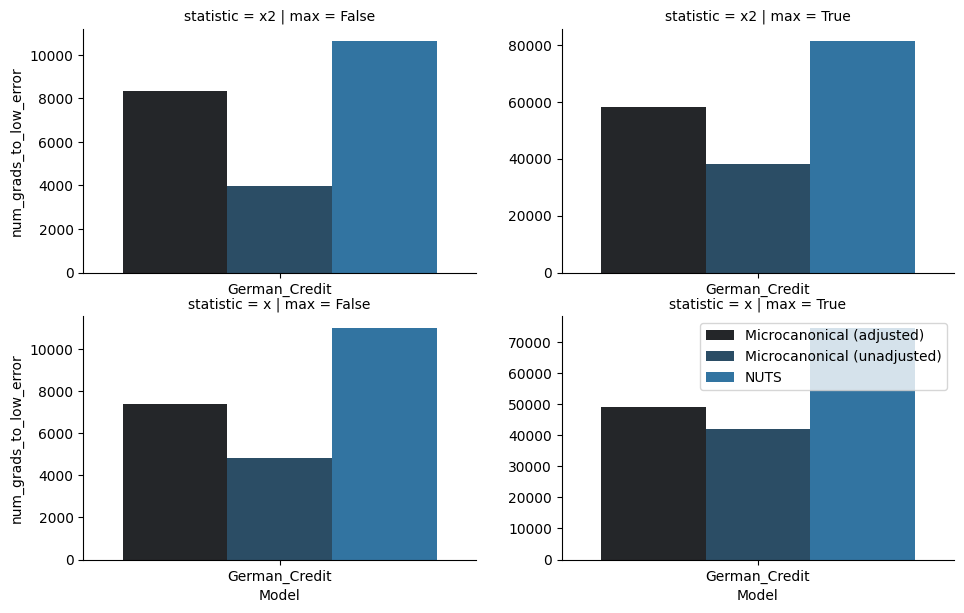

In [4]:
import numpy as np


def display_results(model_name,df, include_tuning=False):

  df["PrettyName"] = df["Sampler"].apply({"nuts": "NUTS", "unadjusted_microcanonical": "Microcanonical (unadjusted)", "adjusted_microcanonical": "Microcanonical (adjusted)"}.get)
  df["total_num_grads_to_low_error"] = df["num_grads_to_low_error"] + df["num_tuning_grads"]
  df = df[df["Model"] == model_name]

  g = sns.FacetGrid(df,
              col='max',
              row="statistic",
              sharex=False,
              sharey=False,
              height=4,
             )
  g = g.map(sns.barplot, 'Model',  'total_num_grads_to_low_error' if include_tuning else "num_grads_to_low_error", "PrettyName",  
            hue_order=np.unique(df["PrettyName"]), 
            order=np.unique(df["Model"]),
            # log_scale=True,
            palette='dark:#1f77b4'
  )
  plt.legend()
  # plt.yscale('log')

  plt.gcf().set_size_inches(10, 6)
  plt.show()

# df

# display_results("Gaussian_100D", df, include_tuning=False)
display_results("German_Credit", df, include_tuning=False)
# display_results("Brownian_Motion", df, include_tuning=False)
# display_results("Brownian_Motion", df, include_tuning=False)
# df

In [3]:
import pickle
import inference_gym.using_jax as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('./sampler-comparison')
sys.path.append('../../')
from sampler_comparison.samplers import samplers
import seaborn as sns



def compare(model):

        dirr = "/global/homes/r/reubenh/blackjax-benchmarks"
        with open(f"{dirr}/sampler-evaluation/sampler_evaluation/models/data/{model.name}_expectations.pkl", "rb") as f:
                stats = pickle.load(f)
                e_x = stats['e_x']
                print("from blackjax run: ", e_x)

        print("from gym: ", model.sample_transformations['identity'].ground_truth_mean)

        
model = gym.targets.VectorModel(gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations(), flatten_sample_transformations=True)

compare(model)

from blackjax run:  [ 0.11525708  0.09256472  0.05635736 -0.03410918 -0.05100336 -0.18196875
 -0.18945307 -0.25923407 -0.25987643 -0.32402724 -0.22958763 -0.28165078
 -0.3362609  -0.38868254 -0.44175696 -0.4945148  -0.5447676  -0.6013282
 -0.6559048  -0.7087315  -0.75866866 -0.8134075  -0.8074223  -0.7784713
 -0.82167107 -0.7737639  -0.743899   -0.7613981  -0.6401507  -0.6669518
 -0.64461184  0.11305185]
from gym:  [ 0.11984811  0.10274264  0.06093274 -0.03870019 -0.04362268 -0.19021639
 -0.1856622  -0.26851514 -0.26010785 -0.3334386  -0.21788554 -0.2735482
 -0.33083084 -0.38252977 -0.43280044 -0.49400684 -0.54860604 -0.60449123
 -0.65569454 -0.7083658  -0.76391494 -0.8189823  -0.8105346  -0.7771473
 -0.8268097  -0.7768991  -0.7374106  -0.7740582  -0.6294383  -0.670295
 -0.6432216   0.10105278]


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

In [3]:
# class Brownian():
#     """
#     log sigma_i ~ N(0, 2)
#     log sigma_obs ~N(0, 2)

#     x ~ RandomWalk(0, sigma_i)
#     x_observed = (x + noise) * mask
#     noise ~ N(0, sigma_obs)
#     mask = 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
#     """

#     def __init__(self):
        
#         self.name = 'Brownian'
#         self.num_data = 30
#         self.ndims = self.num_data + 2

#         # self.E_x, self.E_x2, self.Var_x2, self.cov, self.inv_cov = load_cov(self.name)
        
#         self.data = jnp.array([0.21592641, 0.118771404, -0.07945447, 0.037677474, -0.27885845, -0.1484156, -0.3250906, -0.22957903,
#                                -0.44110894, -0.09830782, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.8786016, -0.83736074,
#                                -0.7384849, -0.8939254, -0.7774566, -0.70238715, -0.87771565, -0.51853573, -0.6948214, -0.6202789])
#         # sigma_obs = 0.15, sigma_i = 0.1

#         self.observable = jnp.concatenate((jnp.ones(10), jnp.zeros(10), jnp.ones(10)))
#         self.num_observable = jnp.sum(self.observable)  # = 20
        

#     def logdensity_fn(self, x):
#         # y = softplus_to_log(x[:2])

#         lik = 0.5 * jnp.exp(-2 * x[1]) * jnp.sum(self.observable * jnp.square(x[2:] - self.data)) + x[
#             1] * self.num_observable
#         prior_x = 0.5 * jnp.exp(-2 * x[0]) * (x[2] ** 2 + jnp.sum(jnp.square(x[3:] - x[2:-1]))) + x[0] * self.num_data
#         prior_logsigma = 0.5 * jnp.sum(jnp.square(x / 2.0))

#         return -lik - prior_x - prior_logsigma


#     def transform(self, x):
#         return jnp.concatenate((jnp.exp(x[:2]), x[2:]))

# class GermanCredit:
#     """ Taken from inference gym.

#         x = (global scale, local scales, weights)

#         global_scale ~ Gamma(0.5, 0.5)

#         for i in range(num_features):
#             unscaled_weights[i] ~ Normal(loc=0, scale=1)
#             local_scales[i] ~ Gamma(0.5, 0.5)
#             weights[i] = unscaled_weights[i] * local_scales[i] * global_scale

#         for j in range(num_datapoints):
#             label[j] ~ Bernoulli(features @ weights)

#         We use a log transform for the scale parameters.
#     """

#     def __init__(self):
        
#         self.name = 'GermanCredit'
#         self.ndims = 51 #global scale + 25 local scales + 25 weights

#         dirr = "../../../../MicroCanonicalHMC/benchmarks/"
        

#         self.labels = jnp.load(dirr + 'data/gc_labels.npy')
#         self.features = jnp.load(dirr + 'data/gc_features.npy')

#         # self.E_x, self.E_x2, self.Var_x2, self.cov, self.inv_cov = load_cov(self.name)
        
        
#     def transform(self, x):
#         return jnp.concatenate((jnp.exp(x[:26]), x[26:]))

#     def logdensity_fn(self, x):

#         scales = jnp.exp(x[:26])

#         # prior
#         pr = jnp.sum(0.5 * scales + 0.5 * x[:26]) + 0.5 * jnp.sum(jnp.square(x[26:]))

#         # transform
#         transform = -jnp.sum(x[:26])

#         # likelihood
#         weights = scales[0] * scales[1:26] * x[26:]
#         logits = self.features @ weights # = jnp.einsum('nd,...d->...n', self.features, weights)
#         lik = jnp.sum(self.labels * jnp.logaddexp(0., -logits) + (1-self.labels)* jnp.logaddexp(0., logits))

#         return -(lik + pr + transform)

sys.path.append(".")
sys.path.append("../../../../sampler-evaluation")
sys.path.append("../../../../MicroCanonicalHMC/benchmarks/")
import os
# print(os.listdir('../../MicroCanonicalHMC/benchmarks/'), "\n\n\n barbarz \n\n\n")

import inference_models
from sampler_evaluation.models.stochastic_volatility import stochastic_volatility

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


['demo.py', 'demo.ipynb']


Exception: Expectations not found: run estimate_expectations.py to generate them

'banana'

In [8]:
Brownian().logdensity_fn(jnp.ones((32,)))

Array(-57.037537, dtype=float32)

In [ ]:
def make_target_log_prob_fn(model):
  def target_log_prob_fn(z):
    x = model.default_event_space_bijector(z)
    return (model.unnormalized_log_prob(x) + 
            model.default_event_space_bijector.forward_log_det_jacobian(z, event_ndims=1))
  return target_log_prob_fn


In [20]:
# from sampler_comparison.samplers.general import initialize_model, make_transform
# from sampler_comparison.samplers.hamiltonianmontecarlo.nuts import nuts
# from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc

# # model = gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations()
# # model = gym.targets.Banana()

# def initialize_model(model, key):

#   def random_initialization(shape, dtype):
#     return jax.tree.map(lambda d, s: jnp.ones(shape=s, dtype=d), dtype, shape)

#   z = jax.tree.map(lambda d, b, s: random_initialization(b.inverse_event_shape(s), d),
#                         model.dtype, model.default_event_space_bijector, model.event_shape)

#   # x = jax.tree.map(lambda z, b: b(z), z, model.default_event_space_bijector)

#   return z

# initial_position = initialize_model(model, key=jax.random.PRNGKey(0))


# model.unnormalized_log_prob(make_transform(model)(initial_position)) 
# # + model.default_event_space_bijector.forward_log_det_jacobian(initial_position, event_ndims=1)
# # model.unnormalized_log_prob(initial_position)

# # jax.tree.map(lambda b, z: b(z), gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations().default_event_space_bijector, foo)

# # BrownianMotionUnknownScalesMissingMiddleObservations().default_event_space_bijector

# # samples, metadata = nuts(return_samples=True)(
# #         # model=gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations(), 
# #         model=model, 
# #         num_steps=1000,
# #         # initial_position=initialize_model(model, key=jax.random.PRNGKey(0)), 
# #         initial_position=initialize_model(model, key=jax.random.PRNGKey(0)), 
# #         key=jax.random.PRNGKey(0))

# # make_transform(model)(initial_position)

# # jax.tree.map(lambda x: 1,make_transform(model)(initial_position))


model = gym.targets.VectorModel(gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations(), flatten_sample_transformations=True)

model.sample_transformations[ "identity"
                        ].ground_truth_mean

# model = gym.targets.VectorModel(gym.targets.GermanCreditNumericSparseLogisticRegression(), flatten_sample_transformations=True)
# model = gym.targets.VectorModel(gym.targets.VectorizedStochasticVolatilityLogSP500(), flatten_sample_transformations=True)
# model.event_shape

# model = gym.targets.VectorModel(gym.targets.SyntheticItemResponseTheory(), flatten_sample_transformations=True)

# model.default_event_space_bijector


# print(jax.grad(target_log_prob_fn)(jnp.ones((51,))))
# print(jax.grad(GermanCredit().logdensity_fn)(jnp.ones((51,))))

# print(jax.grad(make_target_log_prob_fn(model))(jnp.ones((501,))))
# print(jax.grad(inference_models.ItemResponseTheory().logdensity_fn)(jnp.ones((501,))))

# print(jax.grad(make_target_log_prob_fn(model))(jnp.ones((2519,))))
# print(jax.grad(inference_models.StochasticVolatility().logdensity_fn)(jnp.ones((2519,))))
# print(inference_models.StochasticVolatility().logdensity_fn(jnp.ones((2429,))))

# print(target_log_prob_fn(jnp.ones((32,))))
# print(Brownian().logdensity_fn(jnp.ones((32,))))

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

Array([ 0.11984811,  0.10274264,  0.06093274, -0.03870019, -0.04362268,
       -0.19021639, -0.1856622 , -0.26851514, -0.26010785, -0.3334386 ,
       -0.21788554, -0.2735482 , -0.33083084, -0.38252977, -0.43280044,
       -0.49400684, -0.54860604, -0.60449123, -0.65569454, -0.7083658 ,
       -0.76391494, -0.8189823 , -0.8105346 , -0.7771473 , -0.8268097 ,
       -0.7768991 , -0.7374106 , -0.7740582 , -0.6294383 , -0.670295  ,
       -0.6432216 ,  0.10105278], dtype=float32)

In [21]:
# import os
import pickle
# os.listdir("../../../sampler-evaluation/sampler_evaluation/models/data/")
with open(f"../../../sampler-evaluation/sampler_evaluation/models/data/{model.name}_expectations.pkl", "rb") as f:
        stats = pickle.load(f)

e_x = stats["e_x"]
e_x

array([ 0.11523843,  0.11286443,  0.09281074,  0.05646418, -0.03425717,
       -0.05085291, -0.18207422, -0.18943499, -0.2626584 , -0.262576  ,
       -0.32351834, -0.22948493, -0.28225303, -0.33584505, -0.38882157,
       -0.44218862, -0.49562865, -0.5478393 , -0.6018324 , -0.6544354 ,
       -0.7073747 , -0.7601094 , -0.8155371 , -0.81037855, -0.78281546,
       -0.82298577, -0.7782092 , -0.74123335, -0.7644323 , -0.63898563,
       -0.6667262 , -0.643427  ], dtype=float32)

In [25]:

print(gym.targets.VectorModel(gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations(), flatten_sample_transformations=True).sample_transformations["identity"].ground_truth_mean)
print(gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations().sample_transformations["identity"].ground_truth_mean)

[ 0.11984811  0.10274264  0.06093274 -0.03870019 -0.04362268 -0.19021639
 -0.1856622  -0.26851514 -0.26010785 -0.3334386  -0.21788554 -0.2735482
 -0.33083084 -0.38252977 -0.43280044 -0.49400684 -0.54860604 -0.60449123
 -0.65569454 -0.7083658  -0.76391494 -0.8189823  -0.8105346  -0.7771473
 -0.8268097  -0.7768991  -0.7374106  -0.7740582  -0.6294383  -0.670295
 -0.6432216   0.10105278]
{'innovation_noise_scale': array(0.11984811), 'observation_noise_scale': array(0.10105278), 'locs': array([ 0.10274264,  0.06093274, -0.03870019, -0.04362268, -0.19021639,
       -0.1856622 , -0.26851513, -0.26010784, -0.3334386 , -0.21788554,
       -0.27354819, -0.33083084, -0.38252977, -0.43280044, -0.49400684,
       -0.54860601, -0.60449125, -0.65569453, -0.70836578, -0.76391497,
       -0.8189823 , -0.81053462, -0.7771473 , -0.82680971, -0.77689911,
       -0.73741063, -0.7740582 , -0.62943829, -0.67029499, -0.6432216 ])}


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

['demo.py', 'demo.ipynb']


Exception: Expectations not found: run estimate_expectations.py to generate them

NameError: name 'df' is not defined

In [1]:
import sys
sys.path.append('..')
from sampler_comparison.samplers import samplers
from sampler_evaluation.models import banana




2025-02-03 14:05:41.825200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738620341.839458  261284 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738620341.844021  261284 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
from sampler_evaluation.models.rosenbrock import Rosenbrock_36D
import jax.numpy as jnp
import jax

Rosenbrock_36D().unnormalized_log_prob(jax.random.normal(shape=(36,), key=jax.random.PRNGKey(0)))

Array(-233.6276, dtype=float32)

In [5]:
samples, metadata = samplers['nuts'](return_samples=True)(
        model=Rosenbrock_36D(), 
        num_steps=1000,
        initial_position=jnp.ones(36), 
        key=jax.random.PRNGKey(0))

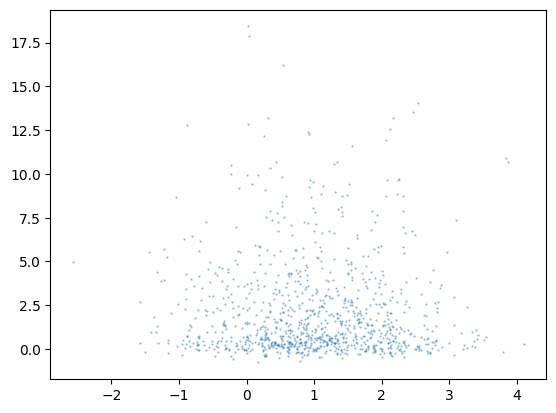

In [8]:
plt.scatter(samples[:,0], samples[:,-1], alpha=0.5, s=0.3)

In [14]:
import os
print(os.listdir())
import sys
sys.path.append(".")
sys.path.append("../../../sampler-comparison")
sys.path.append("../..")

import blackjax
from sampler_comparison.results.run_benchmarks import run_benchmarks
from sampler_comparison.samplers.microcanonicalmontecarlo.adjusted import (
    adjusted_mclmc,
    adjusted_mclmc_tuning,
)
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import (
    unadjusted_mclmc,
    unadjusted_mclmc_tuning,
)
from sampler_comparison.samplers.hamiltonianmontecarlo.nuts import nuts
import sampler_evaluation
from sampler_evaluation.models.rosenbrock import Rosenbrock_36D
# from sampler_evaluation.models.gaussian import Gaussian
from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.brownian import brownian_motion
import jax.numpy as jnp
import blackjax
from sampler_comparison.samplers.hamiltonianmontecarlo.nuts_tuning import da_adaptation
from sampler_comparison.samplers.general import (
    with_only_statistics,
    make_log_density_fn,
)
from sampler_comparison.util import *
from sampler_comparison.samplers.general import initialize_model
import jax


def get_cov_mat_nuts(num_tuning_steps, model, key=jax.random.key(0)):

    integrator_type = "velocity_verlet"



    integrator = map_integrator_type_to_integrator["hmc"][integrator_type]

    # model = brownian_motion()
    logdensity_fn = make_log_density_fn(model)


    warmup = blackjax.window_adaptation(
                    blackjax.nuts, logdensity_fn, integrator=integrator
                )

    warmup_key,init_key = jax.random.split(key)
    initial_position = initialize_model(model, init_key)

    (state, params), adaptation_info = warmup.run(
                    warmup_key, initial_position, num_tuning_steps
                )

    return params["inverse_mass_matrix"], adaptation_info.info.num_integration_steps.sum()


def get_cov_mat_mclmc(num_tuning_steps, model, key=jax.random.key(0)):

    # model = brownian_motion()
    logdensity_fn = make_log_density_fn(model)

    warmup_key,init_key = jax.random.split(key)
    initial_position = initialize_model(model, init_key)

    _, params, num_integrator_steps = unadjusted_mclmc_tuning(
        initial_position=initial_position,
        num_steps=1000,
        rng_key=warmup_key,
        logdensity_fn=logdensity_fn,
        integrator_type="mclachlan",
        diagonal_preconditioning=True,
        num_tuning_steps=num_tuning_steps,
    )

    return params.inverse_mass_matrix, num_integrator_steps

# def get_cov_mat_adjusted_mclmc(num_tuning_steps, model, key=jax.random.key(0)):

#     # model = brownian_motion()
#     logdensity_fn = make_log_density_fn(model)

#     warmup_key,init_key = jax.random.split(key)
#     initial_position = initialize_model(model, init_key)

#     _, params, _ = adjusted_mclmc_tuning(
#         initial_position=initial_position,
#         num_steps=1000,
#         rng_key=warmup_key,
#         logdensity_fn=logdensity_fn,
#         target_acc_rate=0.9,
#         integrator=map_integrator_type_to_integrator["mclmc"]['velocity_verlet'],
#         diagonal_preconditioning=True,
#         num_tuning_steps=num_tuning_steps,
#         L_proposal_factor=jnp.inf,
#         random_trajectory_length=True,
#         tuning_factor=1.0,
        

#     )

#     return params.inverse_mass_matrix

['debug.ipynb', 'other_ppls.ipynb', 'debug.py', 'demo.ipynb', 'other_ppls_2.ipynb']


In [7]:
nuts_inverse_mass_matrix, _ = get_cov_mat_nuts(num_tuning_steps=1000000, model=Rosenbrock_36D()) 

In [15]:
# get_cov_mat_mclmc(num_tuning_steps=100)-nuts_inverse_mass_matrix

results = []
nuts_results = []
adjusted_results = []
num_steps = []
nuts_num_steps = []
for i in [100, 1000, 10000, 100000,]:

    cov_mat, num_integrator_steps = get_cov_mat_mclmc(num_tuning_steps=i, model=Rosenbrock_36D(), key=jax.random.key(1))
    results.append(jnp.linalg.norm(cov_mat-nuts_inverse_mass_matrix).item())
    num_steps.append(num_integrator_steps)


    cov_mat, num_integrator_steps = get_cov_mat_nuts(num_tuning_steps=i, model=Rosenbrock_36D(), key=jax.random.key(1))
    nuts_results.append(jnp.linalg.norm(cov_mat-nuts_inverse_mass_matrix).item()) 
    nuts_num_steps.append(num_integrator_steps)
    # adjusted_results.append(jnp.linalg.norm(get_cov_mat_adjusted_mclmc(num_tuning_steps=i)-nuts_inverse_mass_matrix).item())

[Array(18434, dtype=int32),
 Array(141323, dtype=int32),
 Array(973746, dtype=int32),
 Array(9204909, dtype=int32)]

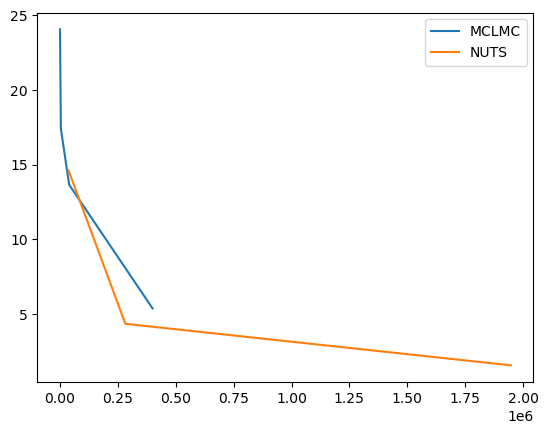

In [27]:
# plot results
import matplotlib.pyplot as plt
plt.plot([i*4 for i in num_steps[:4]], results[:4])
# plt.plot([100, 1000, 10000, 100000,], adjusted_results[:5])
plt.plot([i.item()*2 for i in nuts_num_steps[:3]], nuts_results[:3])
# plt.legend(["MCLMC", "Adjusted MCLMC", "NUTS"])
plt.legend(["MCLMC", "NUTS"])
# plt.yscale('log')
# plt.xscale('log')

# results, adjusted_results

nuts_num_steps

In [28]:
# import sys
0.25*1e6
# import pickle
# sys.path.append('..')
# from sampler_evaluation.models.rosenbrock import Rosenbrock_36D
# import jax.numpy as jnp
# dirr = "/global/homes/r/reubenh/blackjax-benchmarks"

# with open(
#     f"{dirr}/sampler-evaluation/sampler_evaluation/models/data/rosenbrock_36D_expectations.pkl",
#     "rb",
# ) as f:
#     stats = pickle.load(f)

# print(f"New: {stats['e_x']}")

# e_x_old = jnp.array(
#             [
#                 1.0,
#             ]
#             *18
#             + [
#                 2.0,
#             ]
#             *18
#         )



# print(f"Old: {e_x_old}")

250000.0

In [ ]:

# print(f"new x2: {stats['e_x2']}")

# e_x2_old = jnp.array(
#             [
#                 2.0,
#             ]
#             * 18
#             + [
#                 10.10017429,
#             ]
#             * 18
#         )

# print(f"old x2: {e_x2_old}")    

new x2: [ 1.9999614  2.0001338  1.9998589  1.9994991  2.0003493  2.0000134
  1.9993464  2.0006187  1.9998217  2.0003607  1.999792   1.9994425
  2.0002427  1.999335   1.9994446  2.0001912  2.0013323  2.0007448
 11.357674  11.37145   11.363832  11.361152  11.368686  11.367291
 11.36001   11.371172  11.361932  11.372989  11.35868   11.358608
 11.364562  11.353124  11.358071  11.366144  11.378603  11.374646 ]
old x2: [ 2.        2.        2.        2.        2.        2.        2.
  2.        2.        2.        2.        2.        2.        2.
  2.        2.        2.        2.       10.100174 10.100174 10.100174
 10.100174 10.100174 10.100174 10.100174 10.100174 10.100174 10.100174
 10.100174 10.100174 10.100174 10.100174 10.100174 10.100174 10.100174
 10.100174]
